In [3]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 100
DATA_PATH = "G:/gdev/Documents/Data/standard"

train_set = datasets.MNIST(DATA_PATH, train=True, download=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.MNIST(DATA_PATH, train=False, download=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=BATCH_SIZE, shuffle=True)

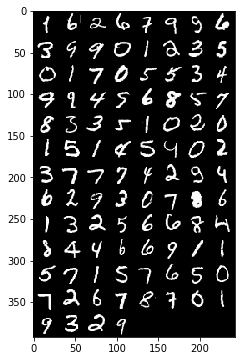

In [5]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.figure(figsize=(8,6))
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
show_images(images)

In [6]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [15]:
class VAE(nn.Module):
    def __init__(self, latent_variable_dim):
        super().__init__()
        self.lvd = latent_variable_dim
        #400 is hidden layer dim
        self.fc1 = nn.Linear(784, 400)
        self.fc2m = nn.Linear(400, latent_variable_dim)
        self.fc2s = nn.Linear(400, latent_variable_dim)
        self.fc3 = nn.Linear(latent_variable_dim, 400)
        self.fc4 = nn.Linear(400, 784)
            
    def reparameterize(self, m, log_s):
        s = torch.exp(log_s / 2)
        eps = torch.randn_like(s) #eps ~ N(0,I)
        return m + s*eps #element-wise product
    
    def encode(self, x):
        #weights used represent parameters phi
        h = torch.relu(self.fc1(x))
        mu = self.fc2m(h)
        log_sigma_sq = self.fc2s(h)
        #treat sigma_sq as already log (taking exp is more numerically stable)
        return mu, log_sigma_sq
    
    def decode(self, z):
        #weights used represent parameters theta
        #equation 11 of Kingma
        x = torch.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        return x
            
    def forward(self, x):
        mu, log_sigma_sq = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_sigma_sq)
        return self.decode(z), mu, log_sigma_sq

ELBO is also the objective function to maximize. KL-term is regularizer, encourages the encoder distribution to follow normal. Monte carlo estimate term is expected reconstruction error. This is same form as the log likelihood error i.e. cross entropy

In [16]:
def loss_function(recon_x, x, m, log_s):
    KL = -1/2 * torch.sum(1 + log_s - m*m - torch.exp(log_s))
    CE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') #sum across all elements
    return KL + CE #returns a torch object

In [39]:
def train(model, optimizer, epochs=1):
    model = model.to(device)
    for e in range(epochs):
        train_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader): #don't need label in AE
            model.train()
            x = x.to(device)
            optimizer.zero_grad()
            
            recon_x, m, log_s = model(x) #returned from forward pass
            loss = loss_function(recon_x, x.view(-1, 784), m, log_s)
            loss.backward() #backward pass, computes gradient of loss w respect to mu, log_sigma_sq, and z
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
                
        print('Epoch %d, average loss = %.4f' % (e, train_loss / len(train_loader.dataset)))
        
def test(model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            recon_x, m, log_s = model(x)
            test_loss += loss_function(recon_x, x.view(-1, 784), m, log_s)
            if i % 100 == 0:
                recon_x = recon_x.view(BATCH_SIZE, 1, 28, 28)
                show_images(recon_x.cpu())
                show_images(x.cpu())
                
    print('Test set loss: %.4f' % (test_loss / len(test_loader.dataset)))

def generate(model):
    with torch.no_grad():
        sample = torch.randn(BATCH_SIZE, model.lvd).to(device)
        sample = model.decode(sample).cpu()
        sample = sample.view(BATCH_SIZE, 1, 28, 28)
        show_images(sample)

In [18]:
model = VAE(40)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, 5)

Iteration 0, loss = 54923.8203
Iteration 100, loss = 18382.0020
Iteration 200, loss = 15792.7705
Iteration 300, loss = 14515.6680
Iteration 400, loss = 13913.6611
Iteration 500, loss = 13399.9297
Epoch 0, average loss = 160.7653
Iteration 0, loss = 13002.3477
Iteration 100, loss = 11741.5293
Iteration 200, loss = 11553.7959
Iteration 300, loss = 12172.4609
Iteration 400, loss = 12240.3457
Iteration 500, loss = 11015.8770
Epoch 1, average loss = 121.3727
Iteration 0, loss = 11522.8320
Iteration 100, loss = 11485.4082
Iteration 200, loss = 11312.4463
Iteration 300, loss = 11582.5654
Iteration 400, loss = 11448.8496
Iteration 500, loss = 11143.0107
Epoch 2, average loss = 114.2610
Iteration 0, loss = 11111.8643
Iteration 100, loss = 11049.0547
Iteration 200, loss = 11059.2051
Iteration 300, loss = 11156.4434
Iteration 400, loss = 11584.2383
Iteration 500, loss = 11180.5322
Epoch 3, average loss = 111.1167
Iteration 0, loss = 10821.9766
Iteration 100, loss = 10799.1328
Iteration 200, loss 

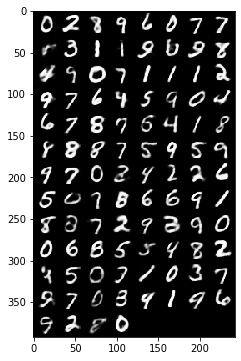

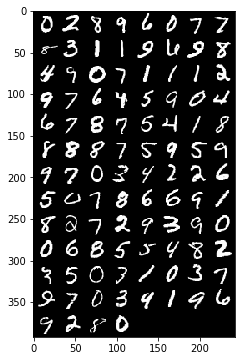

Test set loss: 107.7159


In [27]:
test(model)

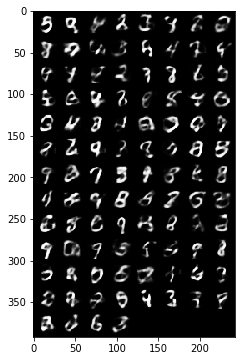

In [40]:
generate(model)